In [205]:
import os
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn import preprocessing 

cwd = os.getcwd()
file = '/'.join(cwd.split('/')) + '/WA_Fn-UseC_-Sales-Win-Loss.csv'
data = pd.read_csv(file, index_col = 0)

In [206]:
# Data Preparition
# First change opportunity result(our target variable) to numeric
data_clean = data.copy()
minority = data_clean['Opportunity Result'].value_counts().idxmin()
result = np.array((data_clean['Opportunity Result'] == minority).astype(int))
data_clean = data_clean.drop(['Opportunity Result'], axis = 1)
# For each categorical variables in the dataset, try to assign an unique indicator variable 
#      for each different category
# (This may not be a good step because it adds too many columns, but we'll see)
for col in data_clean.columns:
    if is_string_dtype(data_clean[col]):
        name_set = set(data_clean[col])
        for name in name_set:
            data_clean[' '.join([col, name, 'indicator'])] = (data_clean[col] == name).astype(int)
        data_clean = data_clean.drop([col], axis = 1)
# Check if there is any null value in our dataset
if data_clean.isnull().any().any():
    print('NO!!!!!')
# Gladly, we don't have any

# Normalize our dataset
scale = preprocessing.StandardScaler()
data_clean = pd.DataFrame(scale.fit_transform(data_clean), columns = data_clean.columns)
data_clean['result'] = result

In [207]:
data

,Supplies Subgroup,Supplies Group,Region,Route To Market,Elapsed Days In Sales Stage,Opportunity Result,Sales Stage Change Count,Total Days Identified Through Closing,Total Days Identified Through Qualified,Opportunity Amount USD,Client Size By Revenue,Client Size By Employee Count,Revenue From Client Past Two Years,Competitor Type,Ratio Days Identified To Total Days,Ratio Days Validated To Total Days,Ratio Days Qualified To Total Days,Deal Size Category
Opportunity Number,,,,,,,,,,,,,,,,,,
1641984,Exterior Accessories,Car Accessories,Northwest,Fields Sales,76,Won,13,104,101,0,5,5,0,Unknown,0.696360,0.113985,0.154215,1
1658010,Exterior Accessories,Car Accessories,Pacific,Reseller,63,Loss,2,163,163,0,3,5,0,Unknown,0.000000,1.000000,0.000000,1
1674737,Motorcycle Parts,Performance & Non-auto,Pacific,Reseller,24,Won,7,82,82,7750,1,1,0,Unknown,1.000000,0.000000,0.000000,1
1675224,Shelters & RV,Performance & Non-auto,Midwest,Reseller,16,Loss,5,124,124,0,1,1,0,Known,1.000000,0.000000,0.000000,1
1689785,Exterior Accessories,Car Accessories,Pacific,Reseller,69,Loss,11,91,13,69756,1,1,0,Unknown,0.000000,0.141125,0.000000,4
1692390,Shelters & RV,Performance & Non-auto,Pacific,Reseller,89,Loss,3,114,0,232522,5,1,0,Unknown,0.000000,0.000877,0.000000,5
1935837,Garage & Car Care,Car Accessories,Pacific,Fields Sales,111,Won,12,112,112,20001,4,5,0,Unknown,0.308863,0.568487,0.122650,2
1952571,Exterior Accessories,Car Accessories,Pacific,Fields Sales,82,Loss,6,70,70,450000,1,1,0,Known,0.263610,0.736390,0.000000,6
1999486,Batteries & Accessories,Car Accessories,Northwest,Fields Sales,68,Loss,8,156,156,250000,1,5,0,None,0.000000,0.562821,0.437179,6


In [212]:
# Since this is just a trial, split training and test data randomly(Later we could use k-fold cross validation)
length = len(data_clean['result'])
train_index = []
test_index = []
for i in range(length):
    train_index.append(i) if np.random.rand() <= 0.8 else test_index.append(i)
data_train = data_clean.iloc[train_index, :]
data_test = data_clean.iloc[test_index, :]

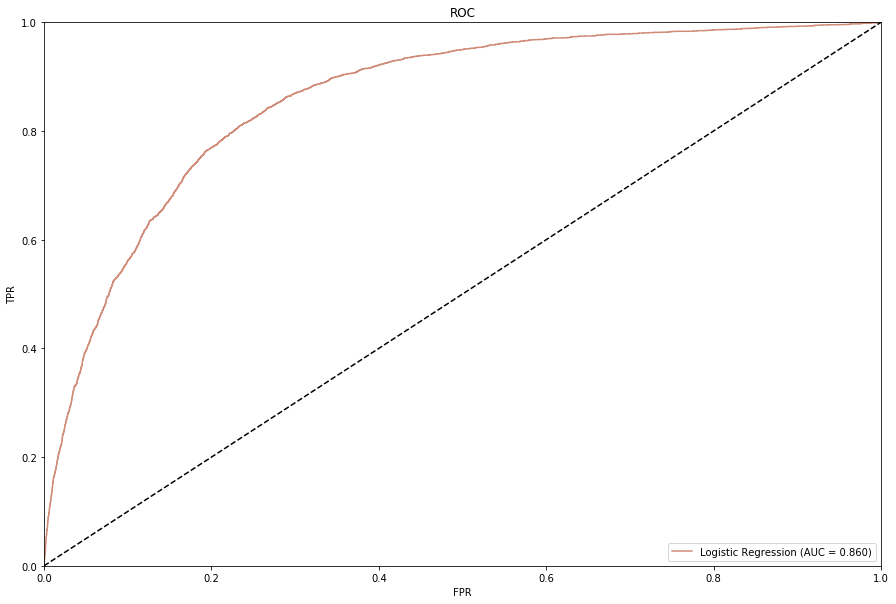

In [213]:
from sklearn import linear_model
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
%matplotlib inline
# Firstly, run a Logistic Regression
lg = linear_model.LogisticRegression(C = 1e30)
lg.fit(data_train.drop(['result'], axis = 1), data_train['result'])
result_lg = lg.predict_proba(data_test.drop(['result'], axis = 1))[:, 1]

def plotROC(preds, truth, name):
    fpr, tpr, thresholds = roc_curve(truth, preds)
    roc_auc = auc(fpr, tpr)
    # chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    #create the plot
    plt.plot(fpr, tpr, color = c, label = name + ' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

# Plot ROC for both models
fig = plt.figure(figsize = (15, 10))
plotROC(result_lg, data_test['result'], 'Logistic Regression')
plt.show()

The above AUC score is quite convincing(to my surprise)...
I think for our problem, since the opportunity amount varies from instance to instance, the profit IBM will get from each instance varies as well. So it's not likely for us to choose a universal threshold for all the instances.

In [214]:
# Do a decision tree and support vector machine and compare them with logistic regression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
DT = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 2000, min_samples_leaf = 200)
DT.fit(data_train.drop(['result'], axis = 1), data_train['result'])
result_DT = DT.predict_proba(data_test.drop(['result'], axis = 1))[:, 1]

I don't know why svm runs so slowly so I separate them.

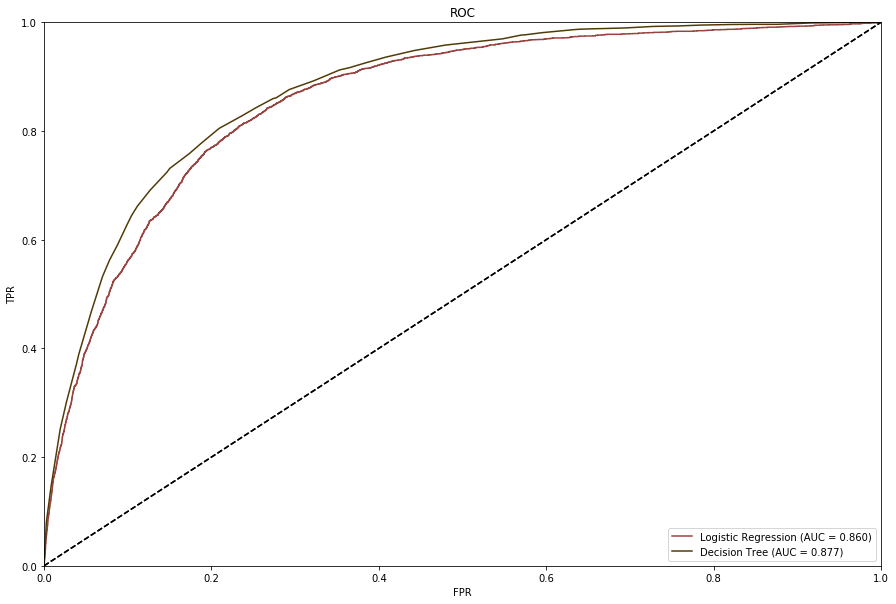

In [215]:
#Plot
fig = plt.figure(figsize = (15, 10))
plotROC(result_lg, data_test['result'], 'Logistic Regression')
#plotROC(result_svm, data_test['result'], 'Support Vector Machine')
plotROC(result_DT, data_test['result'], 'Decision Tree')
plt.show()

In [8]:
# Find feature importances derived by Decision Tree and logistic regression, make it a dataframe
imp = dict(zip(data_clean.columns[0: -1], [[i] for i in DT.feature_importances_]))
feature_imp = pd.DataFrame.from_dict(data = imp, orient = 'index')
feature_imp.columns = ['Decision Tree']
feature_imp['Logistic Regression'] = lg.coef_[0, :]

In [9]:
feature_imp

,Decision Tree,Logistic Regression
Elapsed Days In Sales Stage,0.008990,-0.102602
Sales Stage Change Count,0.100433,0.592781
Total Days Identified Through Closing,0.005648,-0.166994
Total Days Identified Through Qualified,0.324374,-1.193607
Opportunity Amount USD,0.072283,0.347321
Client Size By Revenue,0.000000,0.067715
Client Size By Employee Count,0.000220,0.065656
Revenue From Client Past Two Years,0.208759,0.605146
Ratio Days Identified To Total Days,0.023203,-0.656303
Ratio Days Validated To Total Days,0.009011,-0.457036


It seems like most of the indicator variable doesn't have much influence on the classfication

In [216]:
# 2nd Edit
# svm first
svm = svm.SVC(kernel = "linear")
svm.fit(data_train.drop(['result'], axis = 1), data_train['result'])
result_svm = svm.decision_function(data_test.drop(['result'], axis = 1))

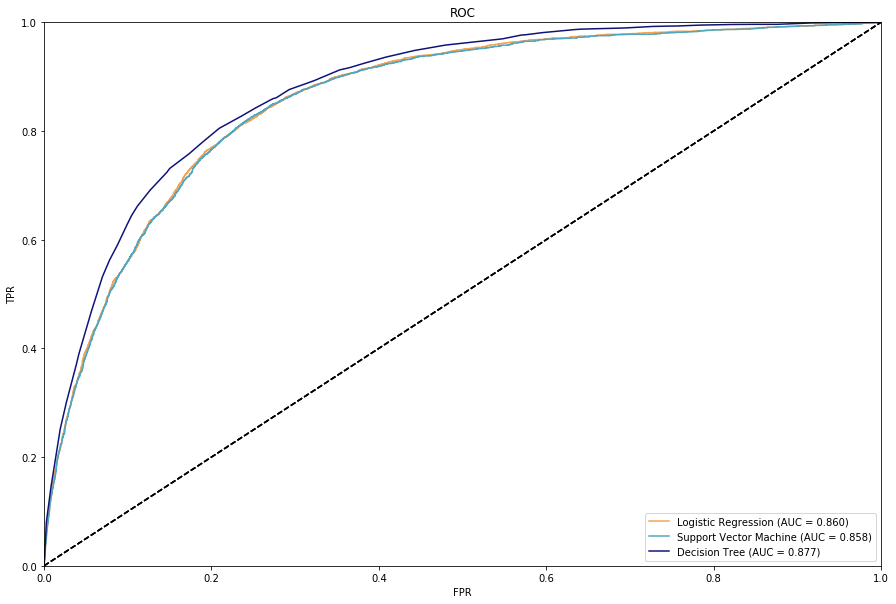

In [217]:
fig = plt.figure(figsize = (15, 10))
plotROC(result_lg, data_test['result'], 'Logistic Regression')
plotROC(result_svm, data_test['result'], 'Support Vector Machine')
plotROC(result_DT, data_test['result'], 'Decision Tree')
plt.show()

It seems like svm and logistic regression have similar result and decision tree is performing way better.<br>
Now try different parameters and find the best model for each method

In [26]:
# Find best parameter for DT and svm
from sklearn import svm
from sklearn.model_selection import KFold
def find_best_parameter(k, cs, min_split_values, min_leaf_values):
    # Create a KFold using parameter k and create an empty dictionary
    KF = KFold(n_splits = k)
    aucs_dt = {}
    aucs_svm = {}
    # Dividing dataset by folds
    for train_ind, test_ind in KF.split(data_clean):
        cv_train = data_clean.iloc[train_ind]
        cv_validate = data_clean.iloc[test_ind]
        # Find best parameter for Decision Tree
        # Calculate roc_auc_score for different c and store them in the dictionary
        count = len(min_split_values)
        for i in range(0, count):
            for j in range(0, count):
            # Construct a decision tree for each set of values
                dt = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = min_split_values[i],
                                   min_samples_leaf = min_leaf_values[j])
                dt.fit(cv_train.drop('result', 1), cv_train['result'])
                result_DT = DT.predict_proba(cv_validate.drop(['result'], axis = 1))[:, 1]
                aucdt = roc_auc_score(cv_validate['result'], result_DT)
                key = (' ').join([str(i), str(j)])
                if key in aucs_dt:
                    aucs_dt[key].append(aucdt)
                else:
                    aucs_dt[key] = [aucdt]
        for c in cs:
            new_svm = svm.SVC(C = c, kernel = "linear", gamma = 'auto')
            new_svm.fit(cv_train.drop(['result'], axis = 1), cv_train['result'])
            aucsvm = roc_auc_score(cv_validate['result'], 
                                    new_svm.decision_function(cv_validate.drop(['result'], axis = 1)))
            if c in aucs_svm:
                aucs_svm[c].append(aucsvm)
            else:
                aucs_svm[c] = [aucsvm]
    return [aucs_dt, aucs_svm]

In [79]:
min_samples_split_values = []
min_samples_leaf_values = []
for i in range(1, 31):
    min_samples_split_values.append(100 * i)
    min_samples_leaf_values.append(10 * i)
cs = [10 ** i for i in range(-8, 2)]
aucs = find_best_parameter(10, cs, min_samples_split_values, min_samples_leaf_values)

TypeError: 'dict_keys' object is not callable

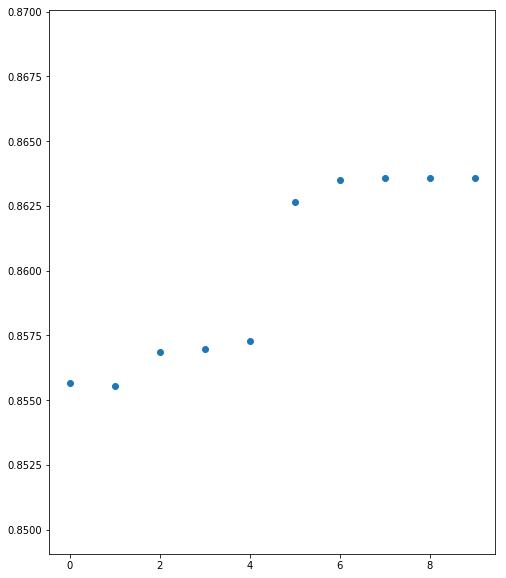

In [202]:
# svm_res = aucs[1]
svm_parameter = [np.mean(svm_res[key]) for key in svm_res]
fig = plt.figure(figsize = (8, 10))
plt.scatter(range(0, len(svm_parameter)), svm_parameter)
plt.xticks(range(0, 10), np.arange(10))
#list(svm_res.keys()))

In [80]:
# I realized that there is an error when doing the finding parameter for dt part in the previous cell, since 
# I don't want to rerun the whole process(the previous cell contains svm as well), so I write this cell and 
# calculate the parameter for dt only.
def find_best_parameter_dt(k, min_split_values, min_leaf_values):
    # Create a KFold using parameter k and create an empty dictionary
    KF = KFold(n_splits = k)
    aucs_dt = {}
    # Dividing dataset by folds
    for train_ind, test_ind in KF.split(data_clean):
        cv_train = data_clean.iloc[train_ind]
        cv_validate = data_clean.iloc[test_ind]
        # Find best parameter for Decision Tree
        # Calculate roc_auc_score for different c and store them in the dictionary
        count = len(min_split_values)
        for i in range(0, count):
            for j in range(0, count):
            # Construct a decision tree for each set of values
                dt = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = min_split_values[i],
                                   min_samples_leaf = min_leaf_values[j])
                dt.fit(cv_train.drop('result', 1), cv_train['result'])
                result_DT = dt.predict_proba(cv_validate.drop(['result'], axis = 1))[:, 1]
                aucdt = roc_auc_score(cv_validate['result'], result_DT)
                key = (' ').join([str(min_split_values[i]), str(min_leaf_values[j])])
                if key in aucs_dt:
                    aucs_dt[key].append(aucdt)
                else:
                    aucs_dt[key] = [aucdt]
    return aucs_dt

In [81]:
# Get the best parameter for decision tree
dt_res = find_best_parameter_dt(10, min_samples_split_values, min_samples_leaf_values)

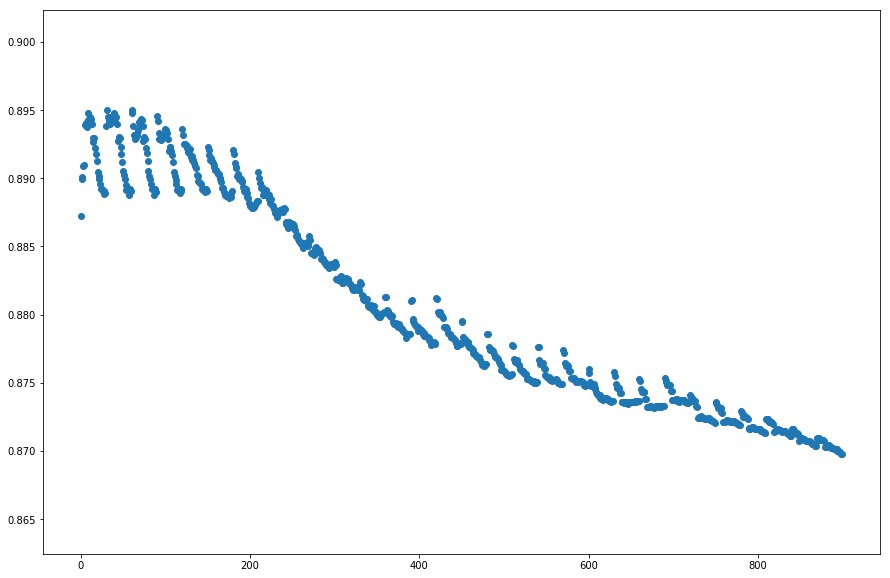

In [83]:
# Plot the different auc score for different parameters in decision tree
dt_parameter = [np.mean(dt_res[key]) for key in dt_res]
fig = plt.figure(figsize = (15, 10))
plt.scatter(range(0, len(dt_parameter)), dt_parameter)

In [84]:
# Find the best parametor for svm and decision tree
bestkey_dt = list(dt_res.keys())[np.argmax(dt_parameter)]
print(str(bestkey_dt) + ' with result auc: ' + str(np.max(dt_parameter)))
# svm
bestkey_svm = list(svm_res.keys())[np.argmax(svm_parameter)]
print(str(bestkey_svm) + ' with result auc: ' + str(np.max(svm_parameter)))

200 20 with result auc: 0.8949972164304031
10 with result auc: 0.8635817470149529


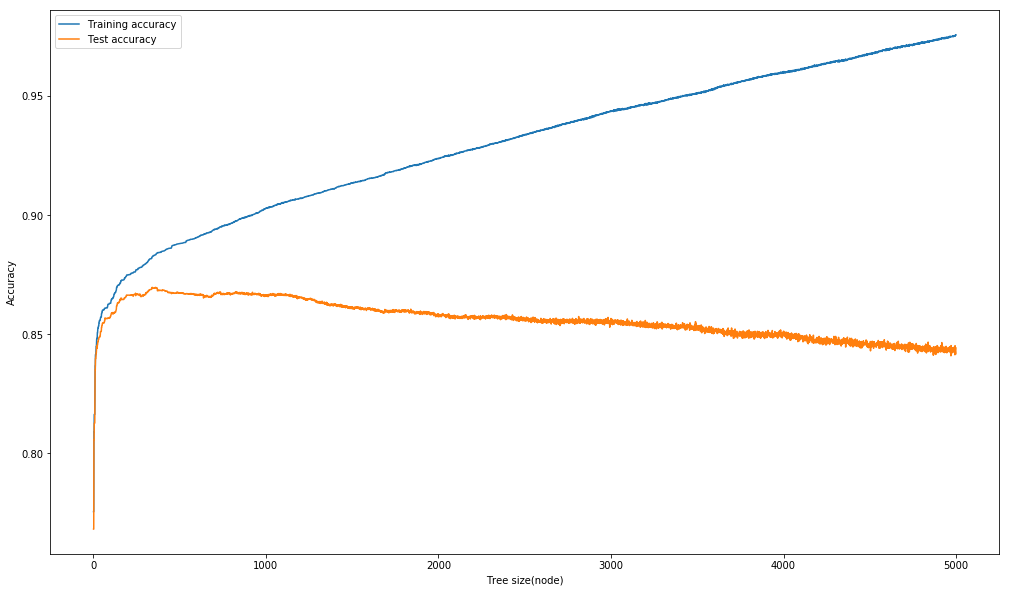

In [74]:
# Drow a plot relating accuracy for training set and test set with tree nodes
from sklearn.metrics import accuracy_score
acc_train = []
acc_test = []
for i in range(2, 5000):
    dt_plot = DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes = i)
    dt_plot.fit(data_train.drop(['result'], axis = 1), data_train['result'])
    acc_train.append(accuracy_score(data_train['result'], 
                                    dt_plot.predict(data_train.drop(['result'], axis = 1))))
    acc_test.append(accuracy_score(data_test['result'], 
                                    dt_plot.predict(data_test.drop(['result'], axis = 1))))
x_axis = np.array(range(2, 5000))
fig_dt = plt.figure(figsize = (17,10))
plt.plot(x_axis, acc_train, label = 'Training accuracy')
plt.plot(x_axis, acc_test, label = 'Test accuracy')
plt.xlabel("Tree size(node)")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [82]:
# Find the tree nodes number that output the best test set prediction accuracy rate
index_max = acc_test[np.argmax(acc_test) - 2]
print(str(index_max) + ' has best performace with a accuracy score ' + str(np.max(acc_test)))

0.8693483202828998

In [157]:
# Now try to plot a profit curve
# Firstly, do a train-test split and train classifiers using the best parameter we have found above
X_train = data_train.drop('result', axis = 1)
Y_train = data_train['result']
X_test = data_test.drop('result', axis = 1)
Y_test = data_test['result']
# Now train models
profit_dt = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 200,min_samples_leaf = 20) 
profit_dt.fit(X_train, Y_train)
prdt_res = profit_dt.predict_proba(X_test)[:, 1]
# Create a dataframe with oppurtunity amount and predicted probability of success for each instance
profit_df_draft = pd.DataFrame({'result': result[test_index], 
              'Opportunity Amount': data['Opportunity Amount USD'].iloc[test_index].values})
profit_df_draft['Predicted Prob'] = prdt_res
profit_df = profit_df_draft.sort_values(by = 'Predicted Prob', ascending = False)
# Create a function to add a column for cumulative opportunity amount
def add_opportunity_amount(cost):
    cumulative_profit = []
    gain = profit_df['Opportunity Amount'].values
    for i in range(len(gain)):
        if i == 0:
            cumulative_profit.append(gain[0] - cost) # Here assume the very top instance has result success
        else:
            if profit_df['result'].iloc[i] == 1:
                cumulative_profit.append(gain[i] + cumulative_profit[i - 1] - cost)
            else:
                cumulative_profit.append(cumulative_profit[i - 1] - cost)
    return cumulative_profit

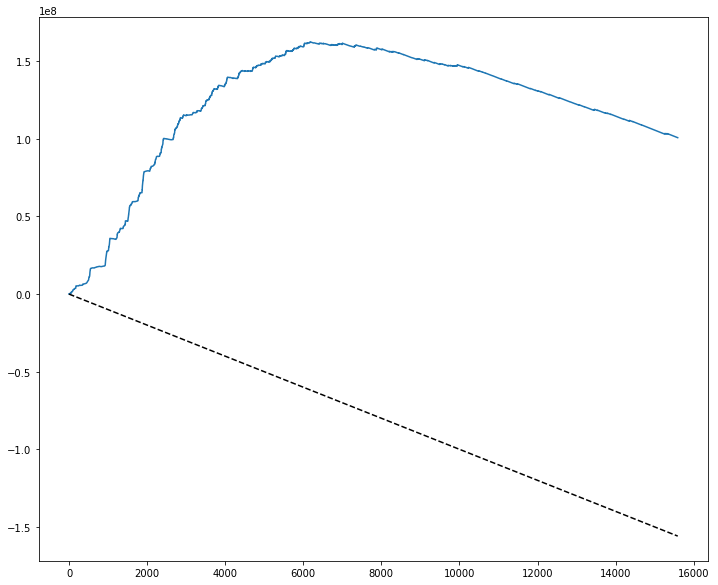

In [179]:
fig = plt.figure(figsize = (12, 10))
cost = 10000 # Change when changing cost
cumulative_profit = add_opportunity_amount(cost)
plt.plot(range(len(cumulative_profit)), cumulative_profit)
plt.plot([0, len(cumulative_profit)], [0, cost * -len(cumulative_profit)], 'k--')
plt.show()

In [197]:
list(svm_res.keys())

[1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]